# Expectation model choices
This notebook explains the rationale for our choice of expectation model.

## Preliminaries

### Import modules

In [1]:
# Import modules
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.proportion import proportions_ztest
from sklearn.metrics import r2_score
from scipy import stats as _stats

# Set seaborn context
sns.set_context("talk")

### Load data

In [2]:
# Load mutational model summary statistics
df = pd.read_csv("../outputs/observed_variants_stats_synonymous.tsv", sep="\t")

# Find the proportion of variants observed
df["obs"] = df["obs"] / df["pos"]

# Exclude CpG transitions
df_cpg = df[df["variant_type"] != "CpG"].copy()

## Plots

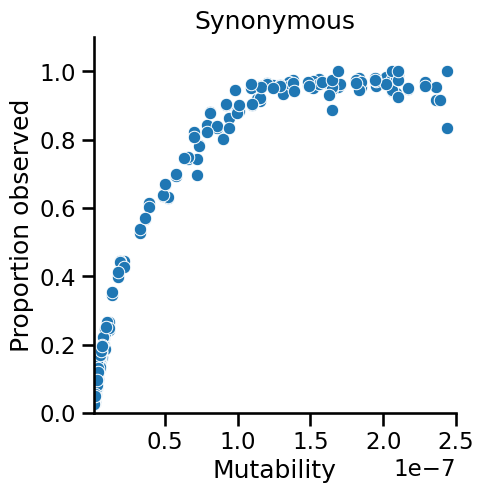

In [3]:
g = sns.relplot(
    kind="scatter",
    data=df,
    x="mu",
    y="obs",
)
(
    g.set(
        xlim=(8.9 * 10**-10, 2.5 * 10**-7),
        ylim=(0, 1.1),
        title="Synonymous",
        xlabel="Mutability",
        ylabel="Proportion observed",
    )
)

This looks like a nice exponential relationship which caps at 1. (The proportion of observed variants can't be >1).

I want to fit a curve which describes this relationship. Later, I want to use this model to predict "obs" (the proportion observed) for other values of "mu" (mutability).

## Exponential model

### Drop saturated contexts

In [4]:
print(f"Contexts = {len(df)}")
print(
    f'There are {(df["obs"]==1).sum()} observations for which "obs" == 1. Drop them.'
)

# Drop saturated contexts
df_nonsat = df[df["obs"] != 1].copy()
print(f"Contexts remaining = {len(df_nonsat)}")

Contexts = 304
There are 5 observations for which "obs" == 1. Drop them.
Contexts remaining = 299


### Fit the model

The approach below matches that in from the gnomAD code base at https://github.com/atgu/gnomad_nc_constraint

In [5]:
# A function to retrieve the standard error of a proportion
def sem(p, n):
    return np.sqrt((p * (1 - p)) / n)

In [6]:
# Fit a polynomial equation
fit = np.polyfit(
    df_nonsat["mu"],
    np.log(1 - df_nonsat["obs"]),
    1,
    w=(1 / sem(df_nonsat["obs"], df_nonsat["pos"])),
)
# Weighted by 1 / sem("obs"), as per gnomAD paper
# Weighting by "pos" is also reasonable

# Create a polynomial evaluator
p = np.poly1d(fit)

A, B = fit  # Get the coefficients
print(f"A = {A}")
print(f"B = {B}")

# The expressions below are equivalent - both are given for clarity
df_nonsat["fit_obs"] = 1 - (np.exp(B)) * (np.exp(A * df_nonsat["mu"]))
df_nonsat["fit_obs"] = 1 - np.exp(p(df_nonsat["mu"]))

# R2 for "obs" vs "fit_obs"
print(
    f'R2 = {np.round(r2_score(df_nonsat["obs"], df_nonsat["fit_obs"]), 5)} for "obs" vs "fit_obs"'
)

A = -23025162.179457773
B = -0.02347085279609953
R2 = 0.9939 for "obs" vs "fit_obs"


### Plots 

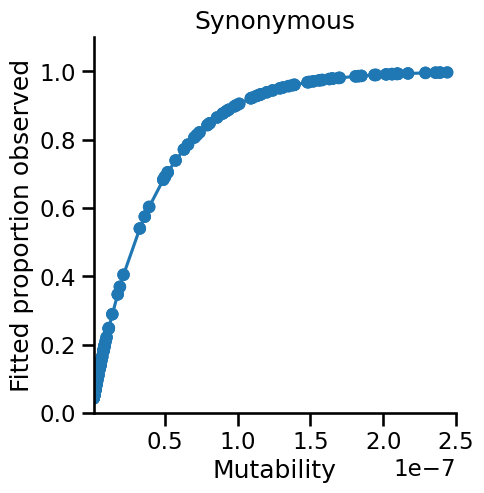

In [7]:
# Plot "mu" vs "fit_obs"
g = sns.relplot(
    kind="scatter",
    data=df_nonsat,
    x="mu",
    y="fit_obs",
    edgecolor="none",
)

# Modify figure
(
    g.set(
        xlim=(8.9 * 10**-10, 2.5 * 10**-7),
        ylim=(0, 1.1),
        title="Synonymous",
        xlabel="Mutability",
        ylabel="Fitted proportion observed",
    )
)

# Add trend line
plt.plot(sorted(df_nonsat["mu"]), sorted(df_nonsat["fit_obs"]))

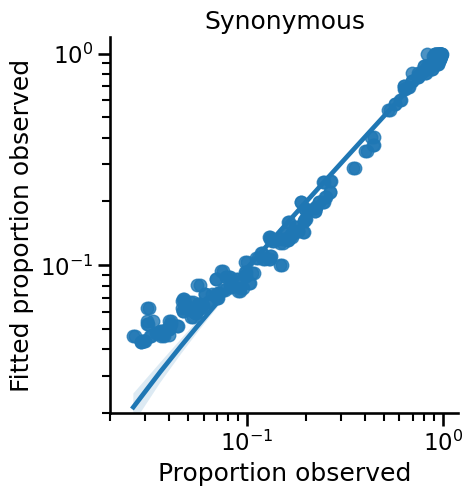

In [8]:
# Plot "obs" vs "fit_obs"
g = sns.lmplot(data=df_nonsat, x="obs", y="fit_obs")
(
    g.set(
        title="Synonymous",
        xlabel="Proportion observed",
        ylabel="Fitted proportion observed",
        xscale="log",
        yscale="log",
        xlim=(0.02, 1.2),
        ylim=(0.02, 1.2),
    )
)

## Linear models

### No weighting

In [9]:
model = smf.wls("obs ~ mu", data=df_cpg).fit()
model.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                    obs   R-squared:                       0.951
Model:                            WLS   Adj. R-squared:                  0.951
No. Observations:                 176   F-statistic:                     3372.
Covariance Type:            nonrobust   Prob (F-statistic):          7.84e-116
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0110      0.002      5.465      0.000       0.007       0.015
mu          2.554e+07    4.4e+05     58.067      0.000    2.47e+07    2.64e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.22e-15. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Weight by number of possible variants

In [10]:
model = smf.wls("obs ~ mu", data=df_cpg, weights=df_cpg["pos"]).fit()
model.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                    obs   R-squared:                       0.959
Model:                            WLS   Adj. R-squared:                  0.959
No. Observations:                 176   F-statistic:                     4083.
Covariance Type:            nonrobust   Prob (F-statistic):          9.71e-123
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0121      0.002      5.790      0.000       0.008       0.016
mu          2.574e+07   4.03e+05     63.897      0.000    2.49e+07    2.65e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.56e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Weight by 1 / standard error of the proportion of observed variants

In [11]:
model = smf.wls(
    "obs ~ mu", data=df_cpg, weights=(1 / sem(df_cpg["obs"], df_cpg["pos"]))
).fit()
model.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                    obs   R-squared:                       0.958
Model:                            WLS   Adj. R-squared:                  0.958
No. Observations:                 176   F-statistic:                     3991.
Covariance Type:            nonrobust   Prob (F-statistic):          6.45e-122
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0084      0.002      4.883      0.000       0.005       0.012
mu          2.613e+07   4.14e+05     63.176      0.000    2.53e+07    2.69e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.35e-12. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Plot the best linear model (weight by number of possible variants)

In [12]:
fit = np.polyfit(df_cpg["mu"], df_cpg["obs"], 1, w=df_cpg["pos"])
p = np.poly1d(fit)

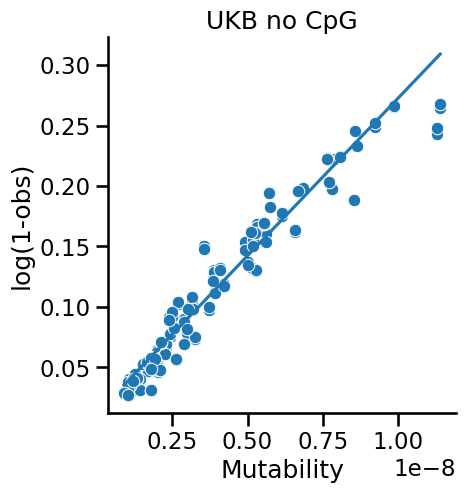

In [13]:
x = df_cpg["mu"].sort_values()
y = p(x)

g = sns.relplot(
    data=df_cpg,
    x="mu",
    y="obs",
)
(
    g.set(
        title="UKB no CpG",
        xlabel="Mutability",
        ylabel="log(1-obs)",
    )
)
plt.plot(x, y)

## Linear model on sqrt(mu)

### No weighting

In [14]:
model = smf.wls(
    "obs ~ np.sqrt(mu)",
    data=df_cpg,
).fit()
model.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                    obs   R-squared:                       0.960
Model:                            WLS   Adj. R-squared:                  0.960
No. Observations:                 176   F-statistic:                     4156.
Covariance Type:            nonrobust   Prob (F-statistic):          2.20e-123
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0831      0.003    -26.682      0.000      -0.089      -0.077
np.sqrt(mu)  3291.2322     51.052     64.469      0.000    3190.472    3391.993
===============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.87e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Weight by number of possible variants

In [15]:
model = smf.wls("obs ~ np.sqrt(mu)", data=df_cpg, weights=df_cpg["pos"]).fit()
model.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                    obs   R-squared:                       0.969
Model:                            WLS   Adj. R-squared:                  0.968
No. Observations:                 176   F-statistic:                     5360.
Covariance Type:            nonrobust   Prob (F-statistic):          1.19e-132
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0877      0.003    -28.678      0.000      -0.094      -0.082
np.sqrt(mu)  3393.2236     46.350     73.209      0.000    3301.743    3484.704
===============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Weight by 1 / standard error of the proportion of observed variants

In [16]:
model = smf.wls(
    "obs ~ np.sqrt(mu)", data=df_cpg, weights=1 / sem(df_cpg["obs"], df_cpg["pos"])
).fit()
model.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                    obs   R-squared:                       0.961
Model:                            WLS   Adj. R-squared:                  0.961
No. Observations:                 176   F-statistic:                     4274.
Covariance Type:            nonrobust   Prob (F-statistic):          2.13e-124
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0826      0.003    -28.436      0.000      -0.088      -0.077
np.sqrt(mu)  3288.9283     50.310     65.374      0.000    3189.633    3388.224
===============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Plot the best sqrt linear model (weight by number of possible variants)

In [17]:
fit = np.polyfit(np.sqrt(df_cpg["mu"]), df_cpg["obs"], 1, w=df_cpg["pos"])
p = np.poly1d(fit)

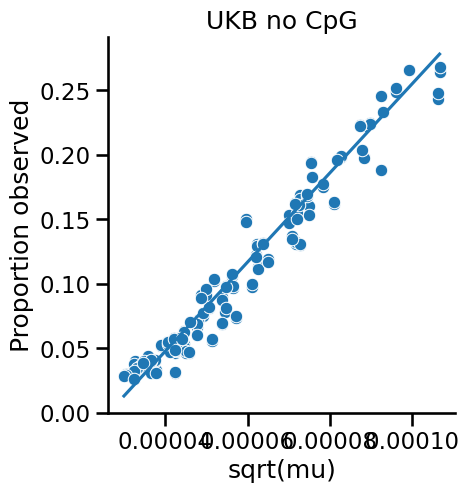

In [18]:
x = np.sqrt(df_cpg["mu"]).sort_values()
y = p(x)

g = sns.relplot(
    data=df_cpg,
    x=np.sqrt(df_cpg["mu"]),
    y="obs",
)
(
    g.set(
        title="UKB no CpG",
        xlabel="sqrt(mu)",
        ylabel="Proportion observed",
    )
)
plt.plot(x, y)

## Log models

### No weighting

In [19]:
model = smf.wls("np.log(1-obs) ~ mu", data=df_cpg).fit()
model.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        np.log(1 - obs)   R-squared:                       0.956
Model:                            WLS   Adj. R-squared:                  0.956
No. Observations:                 176   F-statistic:                     3821.
Covariance Type:            nonrobust   Prob (F-statistic):          2.42e-120
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0050      0.002     -2.289      0.023      -0.009      -0.001
mu          -2.96e+07   4.79e+05    -61.817      0.000   -3.05e+07   -2.87e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.22e-15. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Weight by number of possible variants

In [20]:
model = smf.wls("np.log(1-obs) ~ mu", data=df_cpg, weights=df_cpg["pos"]).fit()
model.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        np.log(1 - obs)   R-squared:                       0.965
Model:                            WLS   Adj. R-squared:                  0.964
No. Observations:                 176   F-statistic:                     4739.
Covariance Type:            nonrobust   Prob (F-statistic):          3.71e-128
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0055      0.002     -2.419      0.017      -0.010      -0.001
mu         -3.002e+07   4.36e+05    -68.840      0.000   -3.09e+07   -2.92e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.56e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Weight by 1 / standard error of the observed proportion

In [21]:
model = smf.wls(
    "np.log(1-obs) ~ mu", data=df_cpg, weights=1 / sem(df_cpg["obs"], df_cpg["pos"])
).fit()
model.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        np.log(1 - obs)   R-squared:                       0.963
Model:                            WLS   Adj. R-squared:                  0.963
No. Observations:                 176   F-statistic:                     4539.
Covariance Type:            nonrobust   Prob (F-statistic):          1.39e-126
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0027      0.002     -1.445      0.150      -0.006       0.001
mu         -3.018e+07   4.48e+05    -67.370      0.000   -3.11e+07   -2.93e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.35e-12. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Plot the best log model (weight by number of possible variants)

In [22]:
fit = np.polyfit(df_cpg["mu"], np.log(1 - df_cpg["obs"]), 1, w=df_cpg["pos"])
p = np.poly1d(fit)

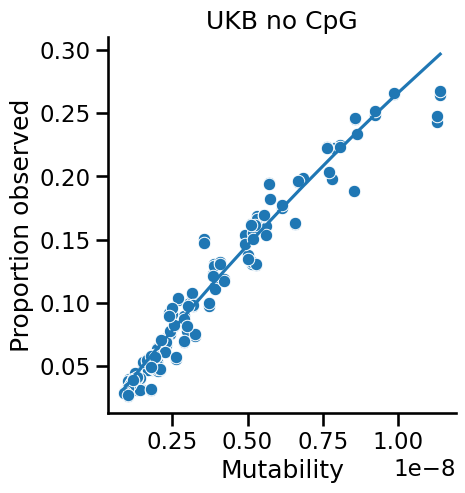

In [23]:
x = df_cpg["mu"].sort_values()
y = 1 - np.exp(p(x))

g = sns.relplot(
    data=df_cpg,
    x="mu",
    y="obs",
)
(
    g.set(
        title="UKB no CpG",
        xlabel="Mutability",
        ylabel="Proportion observed",
    )
)
plt.plot(x, y)

## Choice of models

In [24]:
# Linear model
fit = np.polyfit(df_cpg["mu"], df_cpg["obs"], 1, w=df_cpg["pos"])
lm_p = np.poly1d(fit)

# Square-root model
fit = np.polyfit(np.sqrt(df_cpg["mu"]), df_cpg["obs"], 1, w=df_cpg["pos"])
sqrt_p = np.poly1d(fit)

# Log model
fit = np.polyfit(df_cpg["mu"], np.log(1 - df_cpg["obs"]), 1, w=df_cpg["pos"])
log_p = np.poly1d(fit)

# Log model including CpG data
fit = np.polyfit(
    df_nonsat["mu"], np.log(1 - df_nonsat["obs"]), 1, w=df_nonsat["pos"]
)
cpg_log_p = np.poly1d(fit)

### Get the summary data of possible and observed variants

In [25]:
# No CpG variants
enst = pd.read_csv("../outputs/observed_variants_stats_transcript_no_cpg.tsv", sep="\t")

### Calculate the number of expected variants using each model

In [26]:
def get_expected(df, x):
    """
    Get the expected proportion of variants per transcript and consequence.
    x is a lambda function used to predict the expected value.
    """
    df = (
        df.assign(
            prop_obs=lambda x: x["n_obs"] / x["n_pos"],
            se_prop_obs=lambda x: np.sqrt(
                (x["prop_obs"] * (1 - x["prop_obs"])) / x["n_pos"]
            ),
            prop_exp=x,
            se_prop_exp=lambda x: np.sqrt(
                (x["prop_exp"] * (1 - x["prop_exp"])) / x["n_pos"]
            ),
            n_exp=lambda x: np.round(x["n_pos"] * x["prop_exp"], 2),
            oe=lambda x: x["n_obs"] / x["n_exp"],
            oe_ci_upper=lambda x: (
                x["prop_obs"] + _stats.norm.ppf(0.975) * (x["se_prop_obs"])
            )
            / x["prop_exp"],
            ee_ci_lower=lambda x: (
                x["prop_exp"] - _stats.norm.ppf(0.975) * (x["se_prop_exp"])
            )
            / x["prop_exp"],
            oe_diff=lambda x: (x["oe"] - x["ee_ci_lower"]),
        )
        .set_index(["enst", "csq"])
        .unstack(fill_value=0)
        .stack()
        .reset_index()
    )
    # Z scores and p-values
    df["z"] = df.apply(
        lambda x: (
            proportions_ztest(
                x["n_obs"],
                x["n_pos"],
                x["prop_exp"],
                alternative="smaller",
                prop_var=x["prop_exp"],
            )[0]
        ),
        axis=1,
    )
    df["p"] = df.apply(
        lambda x: proportions_ztest(
            x["n_obs"],
            x["n_pos"],
            x["prop_exp"],
            alternative="smaller",
            prop_var=x["prop_exp"],
        )[1],
        axis=1,
    )
    return df

In [27]:
# No CpGs
enst_lm = get_expected(df=enst, x=lambda x: lm_p(x["mu"]))  # Linear model
enst_sqrt = get_expected(
    df=enst, x=lambda x: sqrt_p(np.sqrt(x["mu"]))
)  # Sqrt model
enst_log = get_expected(
    df=enst, x=lambda x: 1 - np.exp(log_p(x["mu"]))
)  # Log model

/home/alex/miniconda3/ukb/lib/python3.8/site-packages/statsmodels/stats/proportion.py:846: RuntimeWarning: invalid value encountered in double_scalars
  prop = count * 1. / nobs
/home/alex/miniconda3/ukb/lib/python3.8/site-packages/statsmodels/stats/proportion.py:860: RuntimeWarning: invalid value encountered in double_scalars
  p_pooled = np.sum(count) * 1. / np.sum(nobs)
/home/alex/miniconda3/ukb/lib/python3.8/site-packages/statsmodels/stats/proportion.py:862: RuntimeWarning: divide by zero encountered in double_scalars
  nobs_fact = np.sum(1. / nobs)
/home/alex/miniconda3/ukb/lib/python3.8/site-packages/statsmodels/stats/proportion.py:846: RuntimeWarning: invalid value encountered in double_scalars
  prop = count * 1. / nobs
/home/alex/miniconda3/ukb/lib/python3.8/site-packages/statsmodels/stats/proportion.py:860: RuntimeWarning: invalid value encountered in double_scalars
  p_pooled = np.sum(count) * 1. / np.sum(nobs)
/home/alex/miniconda3/ukb/lib/python3.8/site-packages/statsmodel

## Plots

### Expected and observed variants per transcript

In [28]:
def plot_obs_exp_per_transcript(df):
    """Plot number observed vs number expected per transcript"""

    g = sns.lmplot(
        data=df[df.enst != "ENST00000589042"],  # Exclude TTN for visual clarity
        x="n_exp",
        y="n_obs",
        col="csq",
        col_order=["synonymous", "missense", "nonsense"],
        facet_kws={"sharex": False, "sharey": False},
        ci=None,
        robust=True,
    )
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("Expected", "Observed")
    for ax in g.axes[0]:
        ax.axline((0, 0), (1, 1), color="grey", linestyle="--")
    g.fig.subplots_adjust(top=0.8)
    g.fig.suptitle("Variants per transcript")

    return g

Text(0.5, 0.98, 'Variants per transcript (linear model)')

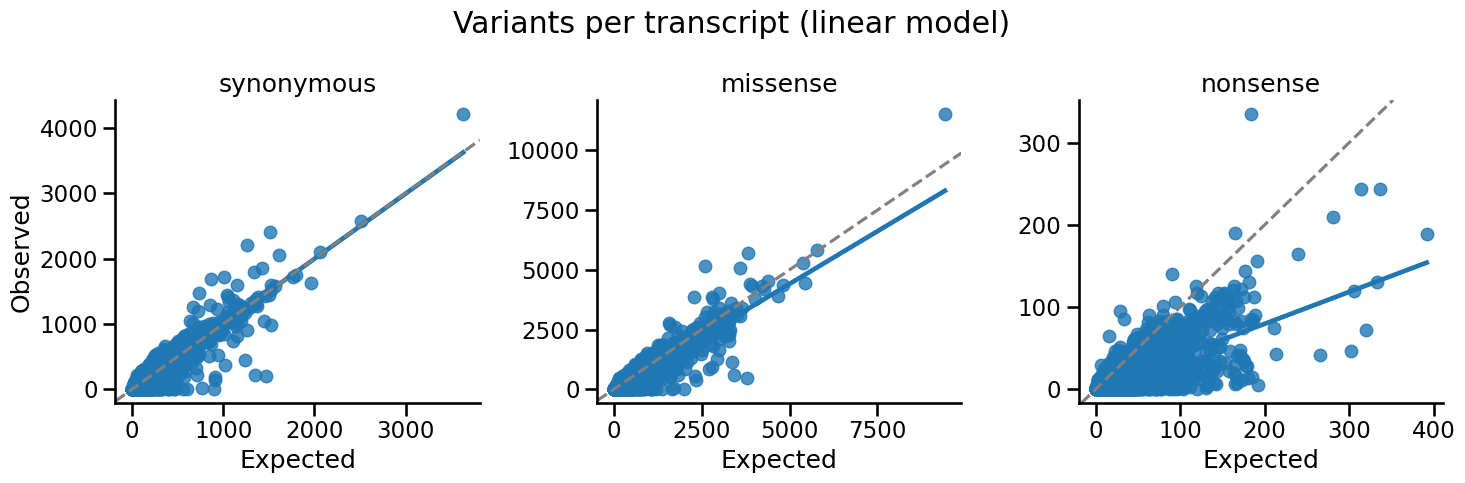

In [29]:
g = plot_obs_exp_per_transcript(enst_lm)
g.fig.suptitle("Variants per transcript (linear model)")

Text(0.5, 0.98, 'Variants per transcript (sqrt model)')

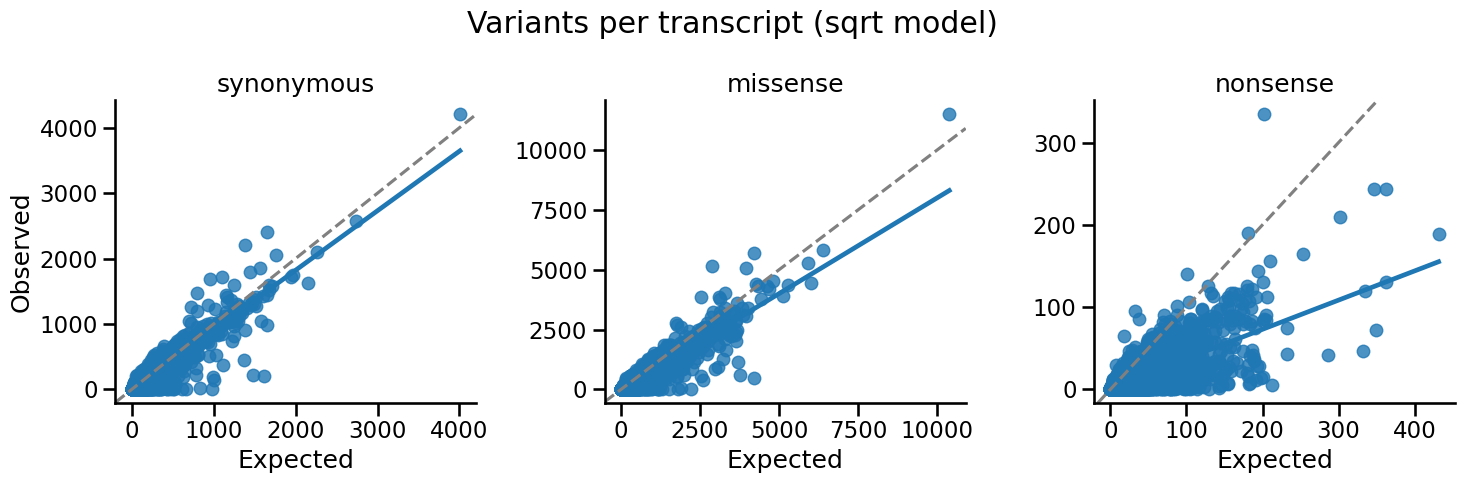

In [30]:
g = plot_obs_exp_per_transcript(enst_sqrt)
g.fig.suptitle("Variants per transcript (sqrt model)")

Text(0.5, 0.98, 'Variants per transcript (log model)')

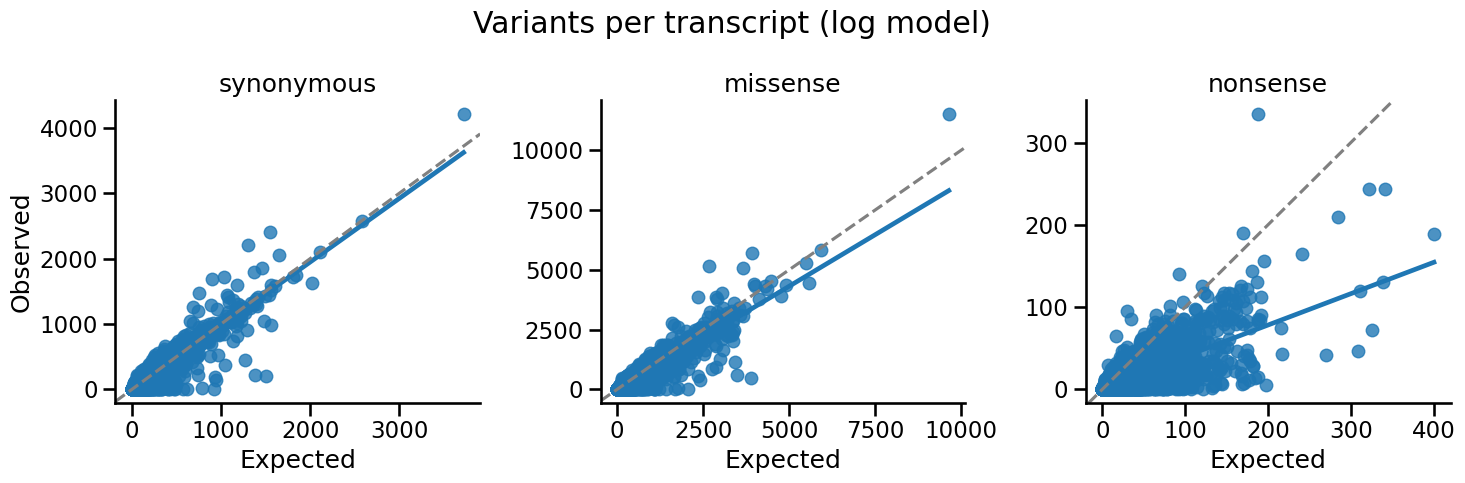

In [31]:
g = plot_obs_exp_per_transcript(enst_log)
g.fig.suptitle("Variants per transcript (log model)")